In [140]:
import os
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

drive.mount("/content/drive", force_remount=True)
os.chdir('/content/drive/MyDrive/Colab Notebooks')

seed = 1234

Mounted at /content/drive


Dataset imported: this dataset is from a survey I ran in 2020. The survey asked participants about their psychological states (e.g.: well-being, loneliness, affect) and social media use habits (e.g.: which social media sites, how many hours of usage, etc).

We have 297 observations and 73 variables. 

I will use it to predict well-being (sats_w_life) from the other variables. 

In [141]:
df = pd.read_csv("socialmedia.csv")
df.head(5)

# changing some columns that caused problem later on the code
df.drop('relationship_stalked', inplace=True, axis=1)
df['Sex'] = np.where(df['Sex'] == 'Female', 1, 0)
df.fillna(df.mean(), inplace=True)


# Creating function to facilitate summary later

summary = list()
def append_summary(method_name, y_test_data, predictions_data):
  # function to make easy append results of t test to a list
  summary.append({"method": method_name, "mean_2_error": mean_squared_error(y_test_data, predictions_data), "root_mean_2_error": np.sqrt(mean_squared_error(y_test_data, predictions_data)), "mean_abs_error": mean_absolute_error(y_test_data, predictions_data), "r2": r2_score(y_test_data, predictions_data)})


Separating between training and testing data.

Goal is 80% training and 20% testing. 

In [142]:
np.random.seed(seed)

random_indexes = np.random.choice(df.index.tolist(), 237, replace=False)
print(random_indexes)

training = df.loc[df.index.isin(random_indexes)]
testing = df.loc[~df.index.isin(random_indexes)]

x_train = training.loc[:, training.columns != 'sats_w_life']
y_train = training.loc[:, training.columns == 'sats_w_life']

x_test = testing.loc[:, testing.columns != 'sats_w_life']
y_test = testing.loc[:, testing.columns == 'sats_w_life']

[ 73 108 269 112 111 122 157 163 295 284 137 271  66  69 100   7 278 176
 170 110 162  99  40   6  22 102 244 106 229 131 104 141 248 148 132 238
  74 225 217  31 125 155 208 124 219 146 193 281 198 167  29  80  67 101
  92 173 221 247 227 115  52 255  24  77  33 201 168  94 267 232 216   5
  97  93 181  95 223  71 149  51 289  83   9 182 214 165  58  48 138  13
  32  63 145 153 160 203  60  91 186 245  27 261  65 166  23 220 187 156
  42 164  44  43 239 134 129 127  54 234 190 202 274 273 237 185 222  59
 272  17  39 253 188 293  25 147 230 259 200  12  56 209 235 191  11 194
 224 287 213  87 215  49 285 126 262 260  61 254  20 179  75   8 264 117
 276 241  35 189   2 205 207  88  36  57  46  79 242 265 144 130 252  15
 292 280 136 150  64 123  68  26  19 250 140 286 270 142   1 169 206 212
 263 192 180 119 196 199  21 210 114 161  90  98 121   0 105 256 183  62
 178 151  78  55 257 103  82   4  28  10  34 291 175 118 266 133 275 228
 135  38 109]


## Regression

In [ ]:
# Copied and modified parameter grid from Dirk's

param_grid = {
    "alpha": [1e-07, 1e-06, 1e-05],
    "penalty": ["l2","elasticnet", "l1"],
    "eta0": [0.03, 0.05, 0.1],
    "max_iter": [500, 1000]
}

regressor = SGDRegressor(loss='squared_error',
                         learning_rate='constant',
                         random_state=seed)
grid_search = GridSearchCV(regressor, param_grid)
grid_search.fit(x_train, y_train)

best_regressor = grid_search.best_estimator_

SGDRegressor(alpha=1e-07, eta0=0.05, learning_rate='constant', max_iter=500,
             penalty='elasticnet', random_state=1234)


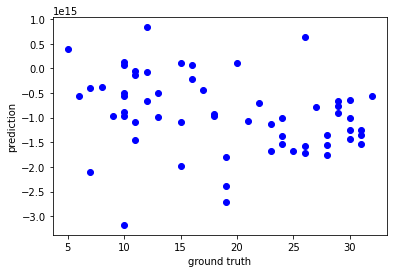

In [144]:
predictions = best_regressor.predict(x_test)

print(best_regressor)

plt.scatter(y_test, predictions, marker='o', c='b')
plt.xlabel('ground truth')
plt.ylabel('prediction')
plt.show()

Performance

In [145]:
append_summary("regression", y_test, predictions)

print(pd.DataFrame(summary))

       method  mean_2_error  root_mean_2_error  mean_abs_error            r2
0  regression  1.469668e+30       1.212298e+15    1.008890e+15 -2.213948e+28


## Random Forests

In [ ]:
param_grid = {
    "n_estimators": [10, 50, 100, 150],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_split": [3, 5, 7]
}

regressor = RandomForestRegressor(n_jobs = -1, random_state = seed)
grid_search = GridSearchCV(regressor, param_grid)
grid_search.fit(x_train, y_train)

RandomForestRegressor(min_samples_split=7, n_estimators=150, n_jobs=-1,
                      random_state=1234)


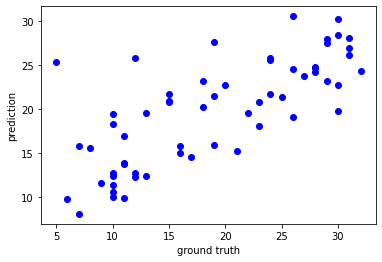

In [147]:
best_regressor = grid_search.best_estimator_

print(best_regressor)

predictions = best_regressor.predict(x_test)

plt.scatter(y_test, predictions, marker='o', c='b')
plt.xlabel('ground truth')
plt.ylabel('prediction')
plt.show()

In [148]:
append_summary("random_forests", y_test, predictions)
print(pd.DataFrame(summary))

           method  mean_2_error  root_mean_2_error  mean_abs_error  \
0      regression  1.469668e+30       1.212298e+15    1.008890e+15   
1  random_forests  3.001583e+01       5.478670e+00    4.153686e+00   

             r2  
0 -2.213948e+28  
1  5.478334e-01  


## Support Vector Regression

In [ ]:
param_grid = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["auto", "scale"],
    "epsilon": [0.1, 0.2, 0.3, 0.5],
    "C": [1.0, 0.1]
}

regressor = SVR()
grid_search = GridSearchCV(regressor, param_grid)
grid_search.fit(x_train, y_train)

SVR(C=0.1, epsilon=0.5, gamma='auto', kernel='linear')


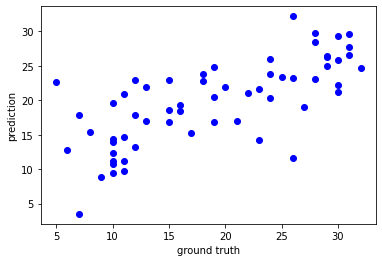

In [175]:
best_regressor = grid_search.best_estimator_
print(best_regressor)

predictions = best_regressor.predict(x_test)

plt.scatter(y_test, predictions, marker='o', c='b')
plt.xlabel('ground truth')
plt.ylabel('prediction')
plt.show()


In [174]:
append_summary("SVR", y_test, predictions)
print(pd.DataFrame(summary))

           method  mean_2_error  root_mean_2_error  mean_abs_error  \
0      regression  1.469668e+30       1.212298e+15    1.008890e+15   
1  random_forests  3.001583e+01       5.478670e+00    4.153686e+00   
2             SVR  3.285435e+01       5.731871e+00    4.432605e+00   
3             SVR  3.285435e+01       5.731871e+00    4.432605e+00   

             r2  
0 -2.213948e+28  
1  5.478334e-01  
2  5.050731e-01  
3  5.050731e-01  


## Overall summary:

The best regressor algorithm to predict life satisfaction from social media use data  was random forests (min_samples_split=7, n_estimators=150, n_jobs=-1, random_state=1234.)